##  Exercise 06 : Scatter Matrix

In [1]:
import pandas as pd
import sqlite3
from pandas.plotting import scatter_matrix

In [2]:
con = sqlite3.connect('../data/checking-logs.sqlite')

In [3]:
con.execute("DROP TABLE IF EXISTS datamart")

In [4]:
con.execute("""CREATE TABLE datamart AS
SELECT c.uid,
       c.labname,
       MIN(c.timestamp) AS first_commit_ts,
       MIN(p.datetime)  AS first_view_ts
FROM checker c
         LEFT JOIN
     pageviews p ON c.uid = p.uid
WHERE c.status = 'ready'
  AND c.numTrials = 1
  AND c.labname IN ('laba04', 'laba04s', 'laba05', 'laba06', 'laba06s', 'project1')
  AND c.uid LIKE 'user_%'
GROUP BY c.uid, c.labname;
            """)

In [5]:
datamart = pd.read_sql("SELECT * FROM datamart", con)
datamart = datamart.astype({'first_commit_ts': 'datetime64[ns]', 'first_view_ts': 'datetime64[ns]'})
test = datamart[datamart['first_view_ts'].notna()].copy()
test.to_sql("test", con, if_exists="replace", index=False)

59

In [6]:
df = pd.read_sql("""
SELECT
    t.uid,
    COUNT(DISTINCT p.rowid) AS pageviews,
    COUNT(DISTINCT c.rowid) AS num_commits,
    AVG((strftime('%s', t.first_commit_ts) - d.deadlines) / 3600.0) AS avg_diff
FROM
    test t
JOIN deadlines d ON t.labname = d.labs
LEFT JOIN pageviews p ON t.uid = p.uid
LEFT JOIN checker c ON t.uid = c.uid AND c.labname != 'project1'
WHERE
    t.uid LIKE 'user_%'
    AND t.first_view_ts IS NOT NULL
    AND t.labname != 'project1'
GROUP BY
    t.uid
""", con)
df

,uid,pageviews,num_commits,avg_diff
0,user_1,28,62,-65.119778
1,user_10,89,20,-75.242444
2,user_14,143,61,-159.568796
3,user_17,47,51,-62.207667
4,user_18,3,5,-6.368148
5,user_19,16,118,-99.440417
6,user_21,10,65,-96.111181
7,user_25,179,79,-93.474944
8,user_28,149,60,-86.793833
9,user_3,317,18,-105.738222


array([[<Axes: xlabel='avg_diff', ylabel='avg_diff'>,
        <Axes: xlabel='pageviews', ylabel='avg_diff'>,
        <Axes: xlabel='num_commits', ylabel='avg_diff'>],
       [<Axes: xlabel='avg_diff', ylabel='pageviews'>,
        <Axes: xlabel='pageviews', ylabel='pageviews'>,
        <Axes: xlabel='num_commits', ylabel='pageviews'>],
       [<Axes: xlabel='avg_diff', ylabel='num_commits'>,
        <Axes: xlabel='pageviews', ylabel='num_commits'>,
        <Axes: xlabel='num_commits', ylabel='num_commits'>]], dtype=object)

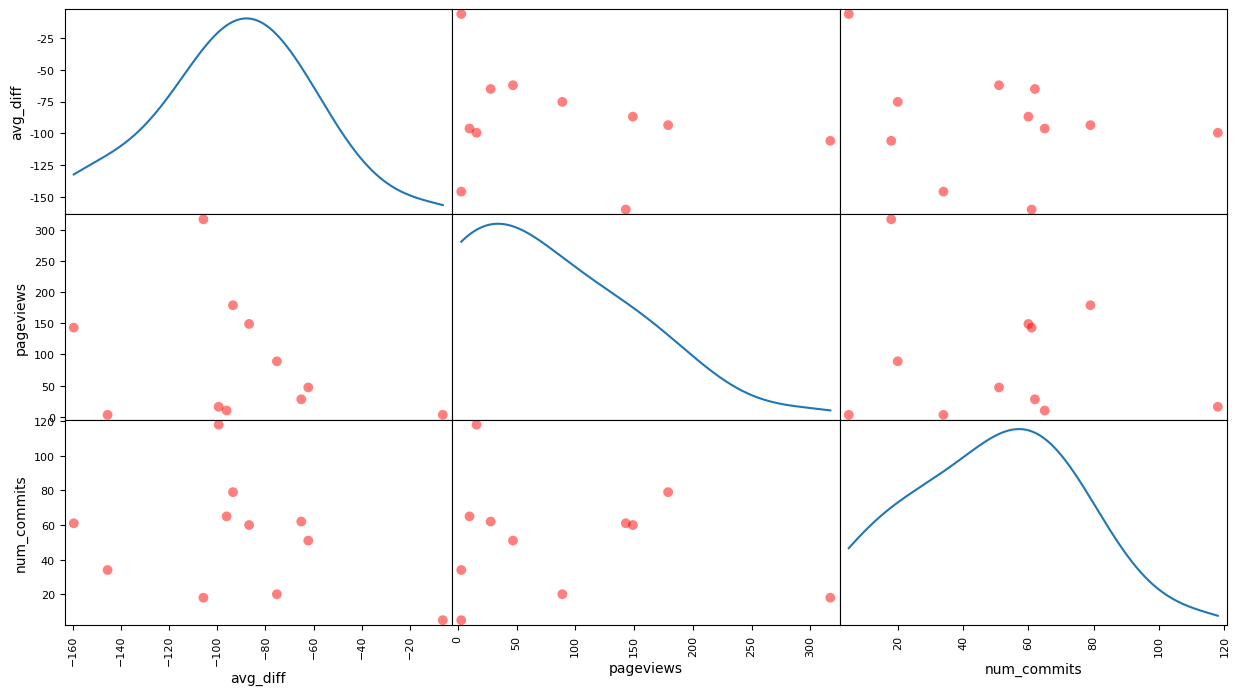

In [7]:
scatter_matrix(
    df[['avg_diff', 'pageviews', 'num_commits']],
    figsize=(15, 8),
    color='red',
    diagonal='kde',
    s=200,
    hist_kwds=dict(linewidth=3)
)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uid          11 non-null     object 
 1   pageviews    11 non-null     int64  
 2   num_commits  11 non-null     int64  
 3   avg_diff     11 non-null     float64
dtypes: float64(1), int64(2), object(1)
memory usage: 484.0+ bytes


### Can we say that if a user has a low number of pageviews then they likely have a low number of commits?
* no

### Can we say that if a user has a low number of pageviews then they likely have a small average difference between the first commit and the lab deadline?
* no

### Can we say that there are many users with a low number of commits and a few with a high number of commits?
* yes

### Can we say that there are many users with a small average difference and a few with a large average difference?
* no